Purpose of this notebook is to get metadata of the experiment from the behavioral data and see how the variables of the experiment look like.
- Need to look at :
1. The distribution of age (time after fertilization)
2. Number of animals and number of frames
2. Number of control vs stimuli (drug and light) data
3. Details regarding the stimuli used (drug conc, light wavelength, light brightness etc)
4. Other variables like time of collection, temperature
5. Get info about the arena
6. Create a metadata file to compile all the above information + details about the raw data videos 

In [1]:
import os, glob

In [2]:
import pandas as pd
from IPython.display import display, HTML

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Video Data 

In [4]:
videos_folder = '/media/athira/Amphioxus1/'

vid_file_list = []

for vid_file in glob.glob("/media/athira/Amphioxus1/2**/**/*INVERTED.avi"):
    vid_file_list.append(vid_file)
print(f'Total number of videos collected: {len(vid_file_list)}')

Total number of videos collected: 828


In [5]:
vid_file_list[240]

'/media/athira/Amphioxus1/20180721/Exp_20180721_131334_1_5m0s_SNAP-5114_None_None/20180721_131334_1_5m0s_SNAP-5114_None_None_INVERTED.avi'

In [6]:
def extract_info_from_filename(file_id, keys=['date','time','crowdsize','duration_m_s','drug','genetics','light','inverted']):
    meta_info = file_id.split('_')
    return {key: meta_info[i] for i, key in enumerate(keys)}   
    

In [7]:
def extract_meta_data(exp_folder_path, keys = ['drugs','duration','age','framerate','dechorionated', 'brightness','infrared']):
    meta_file_path = os.path.join(exp_folder_path, 'metadata.txt')
    df_meta = pd.read_csv(meta_file_path, sep='\t')

    return {key: df_meta[key][0] for key in keys}

In [8]:
def extract_stim_data(exp_folder_path, keys = []):
    meta_file_path = os.path.join(exp_folder_path, 'stimuli_profile.txt')
    df_stim = pd.read_csv(meta_file_path, sep='\t')

    try:
        return {'stim_on':df_stim['time_on'][0], 'stim_off':df_stim['time_off'][0], 'stim_RGB':df_stim['message_on'][0]}
    except KeyError:
        if 'Light' in exp_folder_path:
            print(f'KeyError encountered while trying to get Stimulus information!!!!!!!{exp_folder_path}')
        return {'stim_on':None, 'stim_off':None, 'stim_RGB':None}
        

In [9]:
def extract_temp_data(exp_folder_path, key='temperature'):
    temp_file_path = os.path.join(exp_folder_path, 'logged_temperatures.txt')
    df_temp = pd.read_csv(temp_file_path, sep='\t')
    df_temp[key] = df_temp[key].astype(float)
    
    return {'min_temp':df_temp[key].min(), 'max_temp':df_temp[key].max(), 'median_temp':df_temp[key].mean()}

In [10]:
def extract_meta(filepath):

    result_dict = {}
    exp_folder_path, filename = os.path.split(filepath.values[0])
    file_id, file_root = filename.split('.')
    result_dict['filename_video'] = filename
    result_dict['format'] = file_root
    result_dict['metafile_missing'] = False

    result_dict.update(extract_info_from_filename(file_id))
    
    try:
        result_dict.update(extract_meta_data(exp_folder_path))
        result_dict.update(extract_temp_data(exp_folder_path))
        result_dict.update(extract_stim_data(exp_folder_path))
        
     
    except FileNotFoundError as file_error:
        print('File Not Found !!!')
        print(f'Error message:{file_error}')
        result_dict['metafile_missing'] = True

    return result_dict

    

In [11]:
df_meta_video = pd.DataFrame()
df_meta_video['path_to_video'] = vid_file_list

In [12]:
df_meta_extracted = df_meta_video.apply(lambda x: extract_meta(x), axis=1, result_type='expand') 

File Not Found !!!
Error message:[Errno 2] No such file or directory: '/media/athira/Amphioxus1/20180719/Exp_20180719_110649_1_15m0s_SNAP-5114_None_None/metadata.txt'
File Not Found !!!
Error message:[Errno 2] No such file or directory: '/media/athira/Amphioxus1/20180719/Exp_20180719_124506_1_15m0s_SNAP-5114_None_None/metadata.txt'
File Not Found !!!
Error message:[Errno 2] No such file or directory: '/media/athira/Amphioxus1/20180721/Exp_20180721_111020_1_15m0s_SNAP-5114_None_None/metadata.txt'
File Not Found !!!
Error message:[Errno 2] No such file or directory: '/media/athira/Amphioxus1/20180722/Exp_20180722_180913_1_55m0s_2-AminoEthylHydrogenSulfate_None_None/metadata.txt'
File Not Found !!!
Error message:[Errno 2] No such file or directory: '/media/athira/Amphioxus1/20180722/Exp_20180722_180935_1_55m0s_None_None_None/metadata.txt'


In [13]:
df_meta = pd.concat([df_meta_video, df_meta_extracted], axis='columns')
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 828 entries, 0 to 827
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   path_to_video     828 non-null    object 
 1   filename_video    828 non-null    object 
 2   format            828 non-null    object 
 3   metafile_missing  828 non-null    bool   
 4   date              828 non-null    object 
 5   time              828 non-null    object 
 6   crowdsize         828 non-null    object 
 7   duration_m_s      828 non-null    object 
 8   drug              828 non-null    object 
 9   genetics          828 non-null    object 
 10  light             828 non-null    object 
 11  inverted          828 non-null    object 
 12  drugs             823 non-null    object 
 13  duration          823 non-null    float64
 14  age               823 non-null    float64
 15  framerate         823 non-null    float64
 16  dechorionated     823 non-null    object 
 1

In [14]:
# Remove the rows if metadata file is missing
# If metadata file is missing, I would rather not take that file into consideration !!!

df_meta.drop(df_meta[df_meta['metafile_missing']==True].index, inplace=True)
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
Index: 823 entries, 0 to 827
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   path_to_video     823 non-null    object 
 1   filename_video    823 non-null    object 
 2   format            823 non-null    object 
 3   metafile_missing  823 non-null    bool   
 4   date              823 non-null    object 
 5   time              823 non-null    object 
 6   crowdsize         823 non-null    object 
 7   duration_m_s      823 non-null    object 
 8   drug              823 non-null    object 
 9   genetics          823 non-null    object 
 10  light             823 non-null    object 
 11  inverted          823 non-null    object 
 12  drugs             823 non-null    object 
 13  duration          823 non-null    float64
 14  age               823 non-null    float64
 15  framerate         823 non-null    float64
 16  dechorionated     823 non-null    object 
 17  br

In [15]:
df_meta.sort_values(by=['date', 'time', 'duration_m_s'], inplace=True)

## Check for any inconsistencies in naming or spelling

In [16]:
## Any inconsistencies in naming (spelling, cases) of the drugs?
df_meta.drug.unique()

array(['None', 'SNAP-5114', '2-AminoEthylHydrogenSulfate',
       '2aminoethylHydrogenSulfate', 'Dihydrokainic acid'], dtype=object)

In [17]:
# Seems like 2aminoethylHS is entered in 2 different ways. Will need to fix that inconsistency
df_meta.replace(to_replace='2aminoethylHydrogenSulfate', value='2-AminoEthylHydrogenSulfate', inplace=True)

In [18]:
df_meta.drug.unique()

array(['None', 'SNAP-5114', '2-AminoEthylHydrogenSulfate',
       'Dihydrokainic acid'], dtype=object)

In [19]:
df_meta.light.unique()

array(['None', 'Light'], dtype=object)

In [20]:
df_meta.genetics.unique()

array(['None'], dtype=object)

In [21]:
df_meta.crowdsize.unique()

array(['1', '2'], dtype=object)

In [22]:
len(df_meta[df_meta['crowdsize']=='2'].index)

12

In [23]:
df_meta.duration_m_s.unique()

array(['15m0s', '5m0s', '5m3s', '15m3s'], dtype=object)

In [24]:
df_meta.duration.unique()

array([900., 300., 303., 903.])

In [25]:
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
Index: 823 entries, 39 to 827
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   path_to_video     823 non-null    object 
 1   filename_video    823 non-null    object 
 2   format            823 non-null    object 
 3   metafile_missing  823 non-null    bool   
 4   date              823 non-null    object 
 5   time              823 non-null    object 
 6   crowdsize         823 non-null    object 
 7   duration_m_s      823 non-null    object 
 8   drug              823 non-null    object 
 9   genetics          823 non-null    object 
 10  light             823 non-null    object 
 11  inverted          823 non-null    object 
 12  drugs             823 non-null    object 
 13  duration          823 non-null    float64
 14  age               823 non-null    float64
 15  framerate         823 non-null    float64
 16  dechorionated     823 non-null    object 
 17  b

# Checking for bad recording conditions 

In [278]:
import openpyxl

In [279]:
df_handpick_guide = pd.read_excel('../../../amphioxus_metadata.xlsx', engine='openpyxl')

In [280]:
df_handpick_guide.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  829 non-null    int64  
 1   video_path  829 non-null    object 
 2   score       705 non-null    float64
 3   comments    292 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 26.0+ KB


In [281]:
df_handpicked = df_handpick_guide[(df_handpick_guide['score']==1) & (df_handpick_guide['comments'].isna())]['video_path']

In [282]:
# Let us now try to use this guide to select good videos

df_meta_handpicked = df_meta.merge(df_handpicked, left_on='path_to_video', right_on='video_path')

There is a missing video !!! 

In [283]:
print(f'Number of videos after handpicking is {len(df_meta_handpicked)}')

Number of videos after handpicking is 531


In [284]:
df_meta_handpicked.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 531 entries, 0 to 530
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   path_to_video     531 non-null    object 
 1   filename_video    531 non-null    object 
 2   format            531 non-null    object 
 3   metafile_missing  531 non-null    bool   
 4   date              531 non-null    object 
 5   time              531 non-null    object 
 6   crowdsize         531 non-null    object 
 7   duration_m_s      531 non-null    object 
 8   drug              531 non-null    object 
 9   genetics          531 non-null    object 
 10  light             531 non-null    object 
 11  inverted          531 non-null    object 
 12  drugs             531 non-null    object 
 13  duration          531 non-null    float64
 14  age               531 non-null    float64
 15  framerate         531 non-null    float64
 16  dechorionated     531 non-null    object 
 1

# Examine variables 

In [285]:
df_meta_handpicked.drop(df_meta_handpicked[df_meta_handpicked['framerate']!=30].index, inplace=True)
df_meta_handpicked.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 530
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   path_to_video     500 non-null    object 
 1   filename_video    500 non-null    object 
 2   format            500 non-null    object 
 3   metafile_missing  500 non-null    bool   
 4   date              500 non-null    object 
 5   time              500 non-null    object 
 6   crowdsize         500 non-null    object 
 7   duration_m_s      500 non-null    object 
 8   drug              500 non-null    object 
 9   genetics          500 non-null    object 
 10  light             500 non-null    object 
 11  inverted          500 non-null    object 
 12  drugs             500 non-null    object 
 13  duration          500 non-null    float64
 14  age               500 non-null    float64
 15  framerate         500 non-null    float64
 16  dechorionated     500 non-null    object 
 17  br

In [286]:
df_meta_handpicked.describe()

,duration,age,framerate,brightness,infrared,min_temp,max_temp,median_temp,stim_on,stim_off
count,500.000000,500.000000,500.0,500.0,500.000000,500.000000,500.000000,500.000000,37.000000,37.000000
mean,468.030000,78.756000,30.0,0.0,80.298000,18.619500,18.897000,18.763211,29.189189,87.567568
std,269.663951,22.335582,0.0,0.0,0.799045,0.517814,0.581435,0.534609,4.931970,14.795909
min,300.000000,0.000000,30.0,0.0,79.000000,17.000000,17.250000,17.162815,0.000000,0.000000
25%,300.000000,83.000000,30.0,0.0,80.000000,18.250000,18.500000,18.498866,30.000000,90.000000
50%,300.000000,85.000000,30.0,0.0,80.000000,18.750000,19.000000,18.750000,30.000000,90.000000
75%,900.000000,88.000000,30.0,0.0,80.000000,19.000000,19.250000,19.042310,30.000000,90.000000
max,903.000000,91.000000,30.0,0.0,83.000000,20.000000,20.500000,20.316946,30.000000,90.000000


In [287]:
df_meta_handpicked.describe(include=['object'])[['drugs','drug', 'genetics', 'light', 'stim_RGB', 'inverted','filename_video']]

,drugs,drug,genetics,light,stim_RGB,inverted,filename_video
count,500,500,500,500,37,500,500
unique,4,4,1,2,4,1,500
top,none,None,None,None,n000255000,INVERTED,20180719_114021_1_15m0s_None_None_None_INVERTE...
freq,269,279,500,463,24,500,1


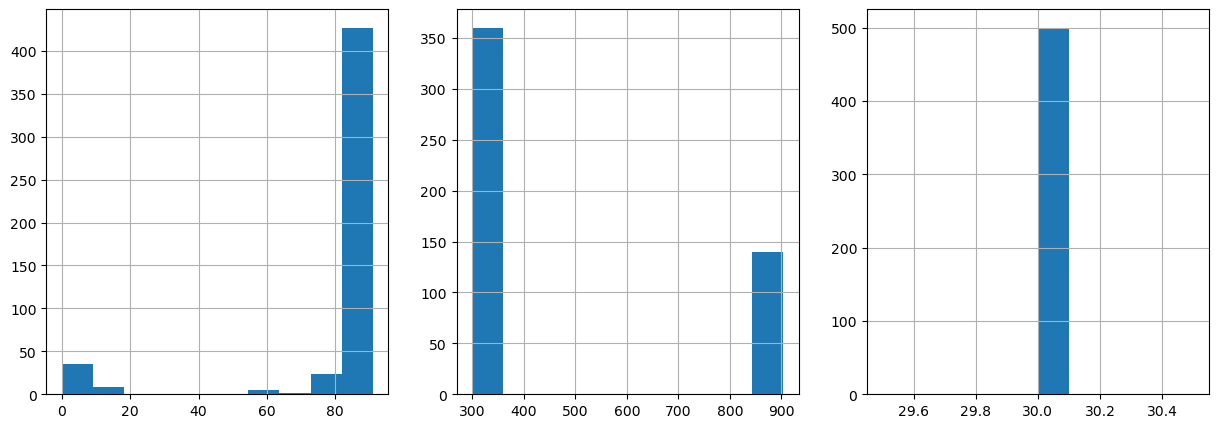

In [288]:
cols_to_plot = ['age', 'duration', 'framerate']
fig, axes = plt.subplots(1,3, figsize = (15,5))
axes = axes.ravel()
for i, col in enumerate(cols_to_plot):
    df_meta_handpicked[col].hist(ax=axes[i])

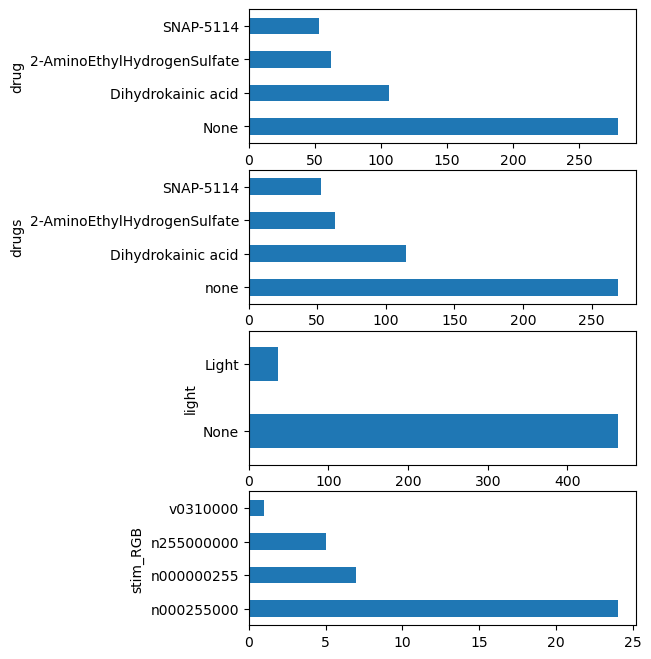

In [289]:
cols_to_plot = ['drug', 'drugs', 'light', 'stim_RGB']
fig, axes = plt.subplots(4,1, figsize = (5,8))
for i, col in enumerate(cols_to_plot):
    df_meta_handpicked[col].value_counts().plot(kind='barh', ax=axes[i])

<AxesSubplot: xlabel='age', ylabel='Count'>

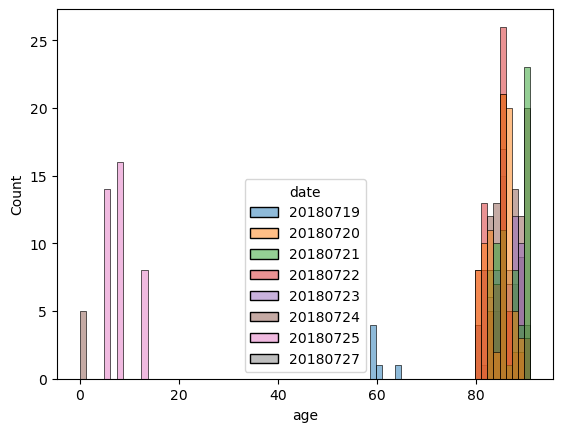

In [290]:
sns.histplot(data=df_meta_handpicked, x='age', hue='date')

In [291]:
# sns.histplot(data=df_meta_handpicked, x='framerate', hue='date')

<AxesSubplot: xlabel='drug', ylabel='Count'>

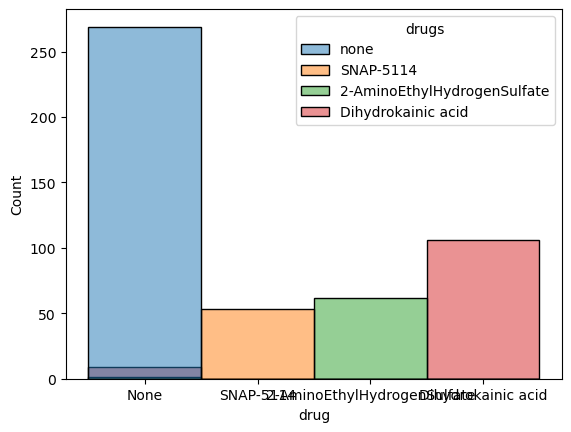

In [292]:
sns.histplot(data=df_meta_handpicked, x='drug', hue='drugs')

<AxesSubplot: xlabel='drugs', ylabel='Count'>

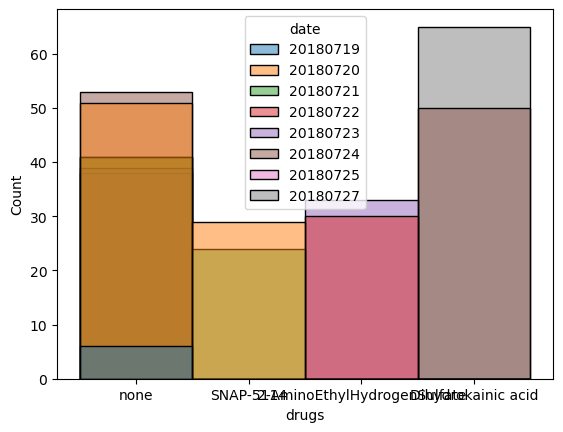

In [293]:
sns.histplot(data=df_meta_handpicked, x='drugs', hue='date')

<AxesSubplot: xlabel='age', ylabel='Count'>

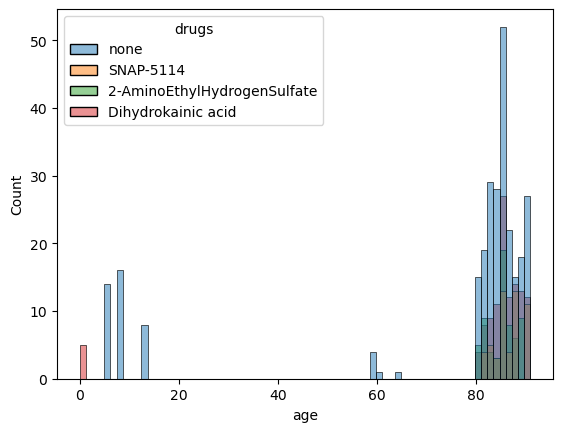

In [294]:
sns.histplot(data=df_meta_handpicked, x='age', hue='drugs')

<AxesSubplot: xlabel='age', ylabel='Count'>

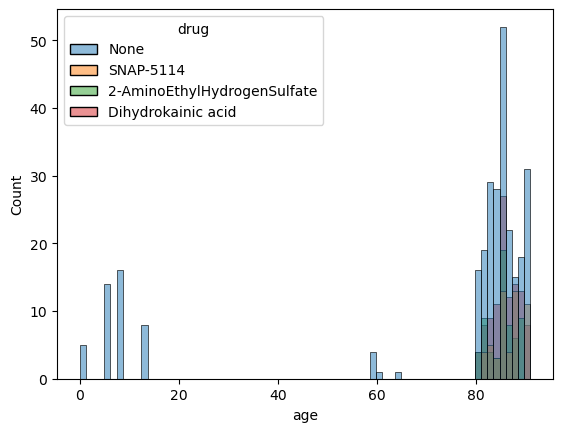

In [295]:
sns.histplot(data=df_meta_handpicked, x='age', hue='drug')

<AxesSubplot: xlabel='age', ylabel='Count'>

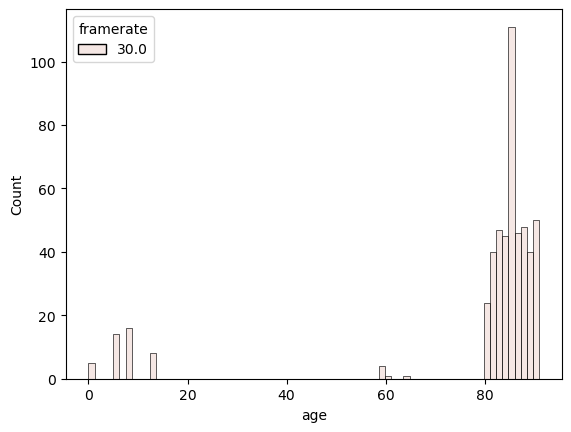

In [296]:
sns.histplot(data=df_meta_handpicked, x='age', hue='framerate')

In [297]:
len(df_meta_handpicked.index)

500

In [298]:
# df_meta_handpicked[(df_meta_handpicked['age'] < 24)]['filename_video'].iloc[0]

# Curated Dataset

In [299]:
df_meta_handpicked.columns

Index(['path_to_video', 'filename_video', 'format', 'metafile_missing', 'date',
       'time', 'crowdsize', 'duration_m_s', 'drug', 'genetics', 'light',
       'inverted', 'drugs', 'duration', 'age', 'framerate', 'dechorionated',
       'brightness', 'infrared', 'min_temp', 'max_temp', 'median_temp',
       'stim_on', 'stim_off', 'stim_RGB', 'video_path'],
      dtype='object')

In [300]:
df_curated = df_meta_handpicked[['path_to_video', 'filename_video', 'date','time', 'light', 'drugs', 'duration', 'age', 'stim_on', 'stim_off', 'stim_RGB']]

# DLC results

In [385]:
dlc_results_folder = '../../data/dlc_results/'

csv_file_list = []

for file in glob.glob(f'{dlc_results_folder}*.h5'):
    csv_file_list.append(file)
print(f'Number of DLC analysed files {len(csv_file_list)}')

Number of DLC analysed files 507


In [386]:
csv_file_list[0]

'../../data/dlc_results/20180724_123551_1_5m0s_None_None_Light_INVERTEDDLC_resnet50_AmphioxusJun19shuffle1_110000_el.h5'

In [387]:
def bool_exist_dlc_result(x, dlc_results_folder = '../../data/dlc_results/'):
    filename  = x.replace('.avi', 'DLC_resnet50_AmphioxusJun19shuffle1_110000_el.h5')
    filepath = os.path.join(dlc_results_folder, filename)
    if os.path.isfile(filepath):
        return filepath

In [388]:
list_dlc_results = df_curated['filename_video'].apply(lambda x: bool_exist_dlc_result(x))

In [389]:
df_curated.loc[:,'dlc_result_file'] = list_dlc_results

In [390]:
df_curated.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 530
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   path_to_video    500 non-null    object 
 1   filename_video   500 non-null    object 
 2   date             500 non-null    object 
 3   time             500 non-null    object 
 4   light            500 non-null    object 
 5   drugs            500 non-null    object 
 6   duration         500 non-null    float64
 7   age              500 non-null    float64
 8   stim_on          37 non-null     float64
 9   stim_off         37 non-null     float64
 10  stim_RGB         37 non-null     object 
 11  dlc_result_file  500 non-null    object 
dtypes: float64(4), object(8)
memory usage: 50.8+ KB


## DLC files are Missing !!! Where did these go ????

In [372]:
df_missing_dlc = df_curated[df_curated['dlc_result_file'].isna()]

In [373]:
df_missing_dlc.date.unique()

array([], dtype=object)

In [374]:
df_missing_dlc

,path_to_video,filename_video,date,time,light,drugs,duration,age,stim_on,stim_off,stim_RGB,dlc_result_file


In [375]:
missing_paths = list(df_missing_dlc['path_to_video'])

In [376]:
len(missing_paths)

0

In [377]:
with open(r'path_to_videos_with_dlc_results_missing3.txt', 'w') as miss_fp:
    for item in missing_paths:
        miss_fp.write(f"{item}\n")

In [378]:
list(df_missing_dlc.path_to_video[:2])

[]

In [379]:
df_missing_dlc[df_missing_dlc['date'] == '20180727']

,path_to_video,filename_video,date,time,light,drugs,duration,age,stim_on,stim_off,stim_RGB,dlc_result_file


<AxesSubplot: >

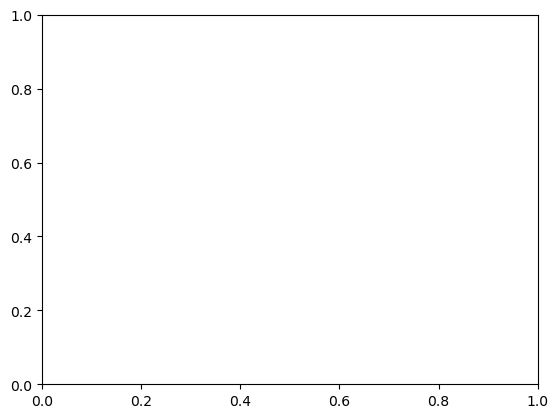

In [380]:
sns.histplot(data=df_missing_dlc, x='age', hue='date')

<AxesSubplot: >

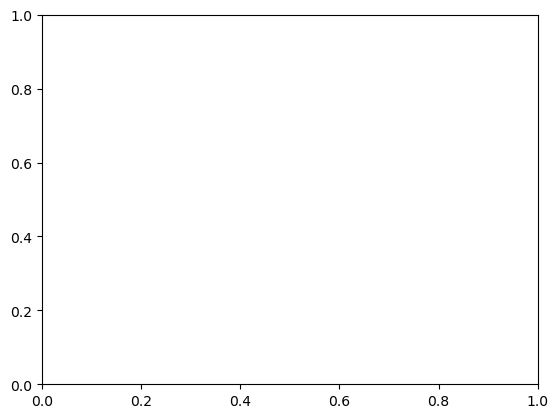

In [381]:
sns.histplot(data=df_missing_dlc, x='age', hue='drugs')

## DLC -ed : What we already have !

In [391]:
df_DLCed = df_curated[df_curated['dlc_result_file'].notna()]

In [392]:
len(df_DLCed.index)

500

<AxesSubplot: xlabel='age', ylabel='Count'>

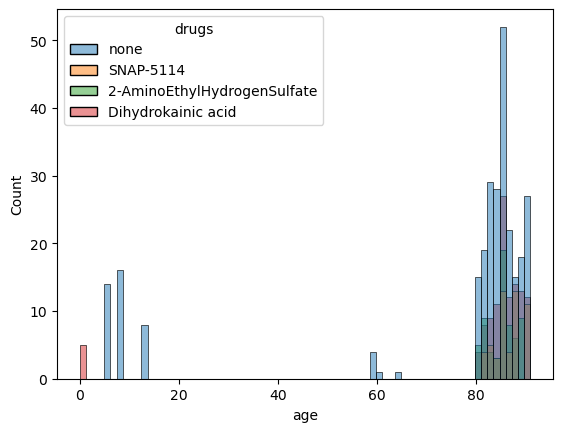

In [394]:
sns.histplot(data=df_DLCed, x='age', hue='drugs')

<AxesSubplot: xlabel='age', ylabel='Count'>

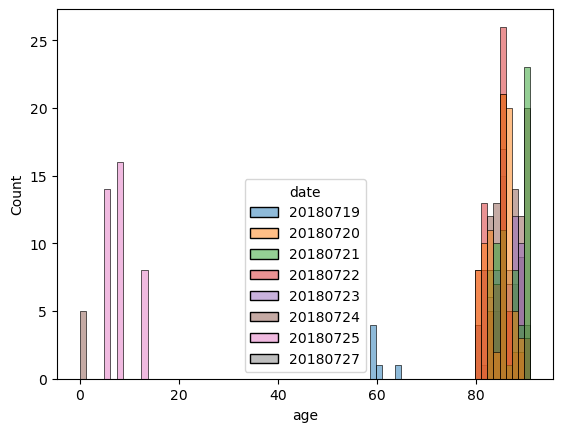

In [395]:
sns.histplot(data=df_DLCed, x='age', hue='date')

<AxesSubplot: xlabel='date', ylabel='Count'>

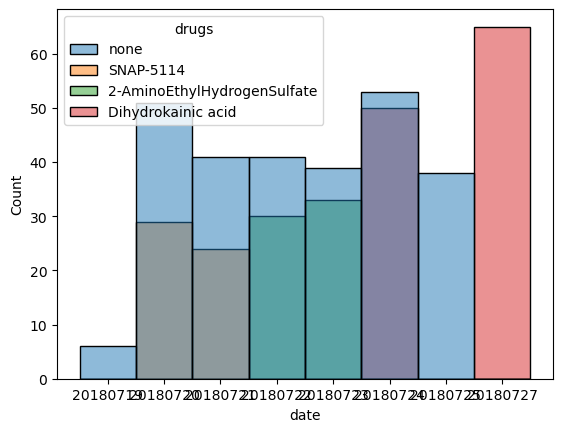

In [396]:
sns.histplot(data=df_DLCed, x='date', hue='drugs')

<AxesSubplot: xlabel='light', ylabel='Count'>

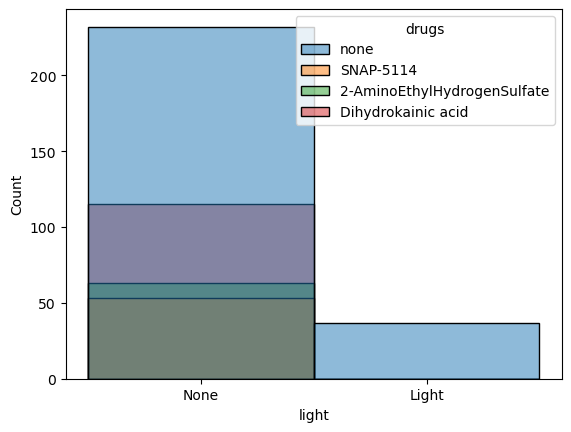

In [397]:
sns.histplot(data=df_DLCed, x='light', hue='drugs')

# Datasets

I can now create a behavioral space and look at how the distribution/occupation varies according to:
- age 
- drug
- light stimulus

In [398]:
df_DLCed['dlc_result_file'].iloc[0]

'../../data/dlc_results/20180719_114021_1_15m0s_None_None_None_INVERTEDDLC_resnet50_AmphioxusJun19shuffle1_110000_el.h5'

In [399]:
with open(r'path_to_videos_with_dlc_results_to_calc_speed.txt', 'w') as fp:
    for item in list(df_DLCed['dlc_result_file']):
        fp.write(f"{item}\n")

In [400]:
df_DLCed.columns

Index(['path_to_video', 'filename_video', 'date', 'time', 'light', 'drugs',
       'duration', 'age', 'stim_on', 'stim_off', 'stim_RGB',
       'dlc_result_file'],
      dtype='object')

In [353]:
df_DLCed[df_DLCed['dlc_result_file'] == '../../data/dlc_results/20180720_093811_1_15m0s_None_None_None_INVERTEDDLC_resnet50_AmphioxusJun19shuffle1_110000_el.h5']['path_to_video'].values

array(['/media/athira/Amphioxus1/20180720/Exp_20180720_093811_1_15m0s_None_None_None/20180720_093811_1_15m0s_None_None_None_INVERTED.avi'],
      dtype=object)

In [354]:
'/media/athira/Amphioxus1/20180720/Exp_20180720_093811_1_15m0s_None_None_None/20180720_093811_1_15m0s_None_None_None_INVERTED.avi'

'/media/athira/Amphioxus1/20180720/Exp_20180720_093811_1_15m0s_None_None_None/20180720_093811_1_15m0s_None_None_None_INVERTED.avi'